✅ Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step - accuracy: 0.3268 - loss: 1.6531 - val_accuracy: 0.3750 - val_loss: 1.0629 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.4609 - loss: 1.1131 - val_accuracy: 0.4583 - val_loss: 1.1987 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.5088 - loss: 1.0083 - val_accuracy: 0.3333 - val_loss: 1.0961 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.5347 - loss: 0.9954 - val_accuracy: 0.3611 - val_loss: 1.0198 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.5889 - loss: 0.9247 - val_accuracy: 0.4861 - val_loss: 1.0016 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.5158 - loss: 0.9616 - val_accuracy: 0.3750 - val_loss: 1.0106 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.4828 - loss: 1.0222 -

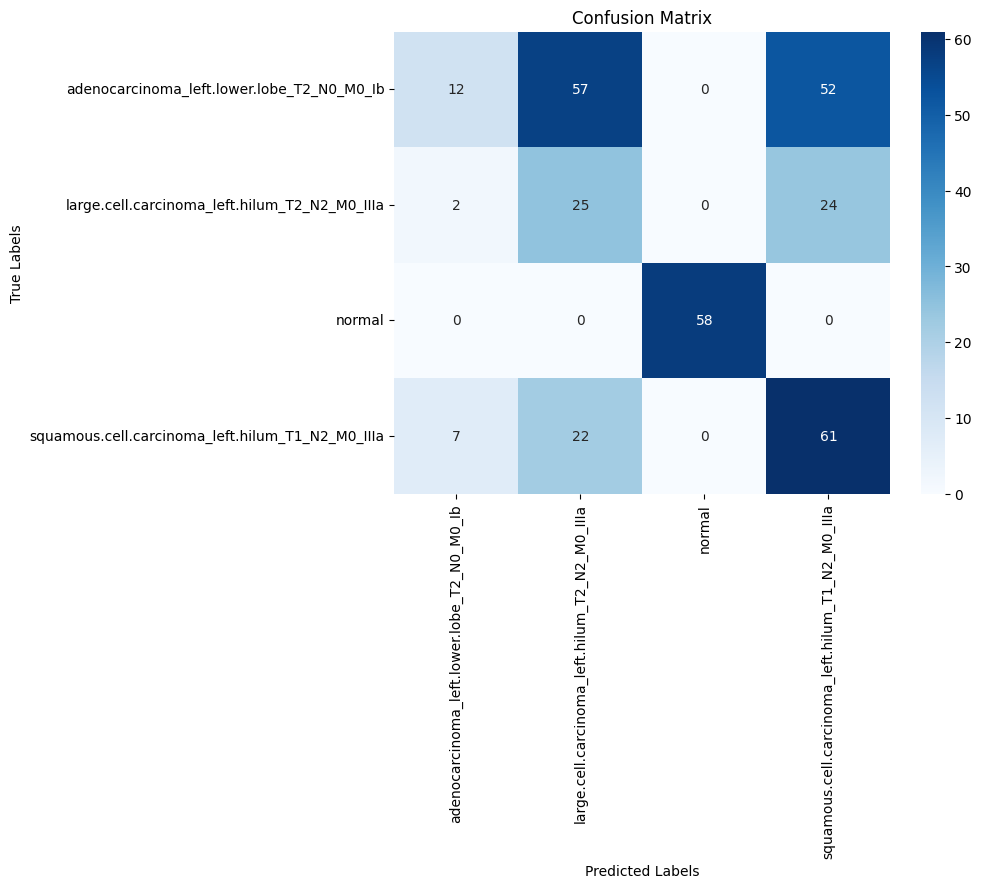

🔹 Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.57      0.10      0.17       121
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.24      0.49      0.32        51
                                          normal       1.00      1.00      1.00        58
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.45      0.68      0.54        90

                                        accuracy                           0.49       320
                                       macro avg       0.56      0.57      0.51       320
                                    weighted avg       0.56      0.49      0.45       320

🔹 Predicted: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa (Malignant) (Confidence: 34.23%)


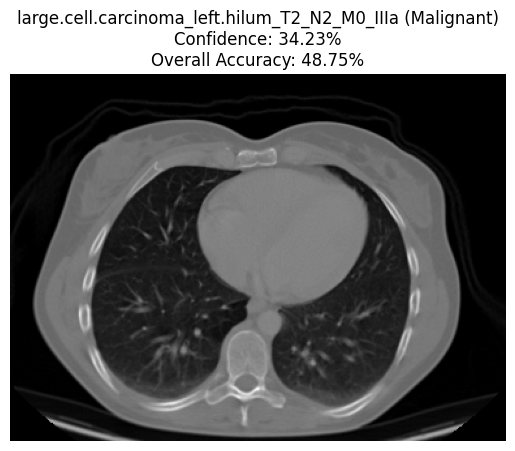

🔹 Predicted: normal (Benign) (Confidence: 85.94%)


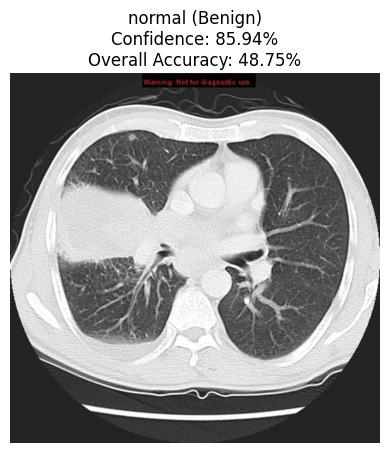

🔹 Predicted: normal (Benign) (Confidence: 52.98%)


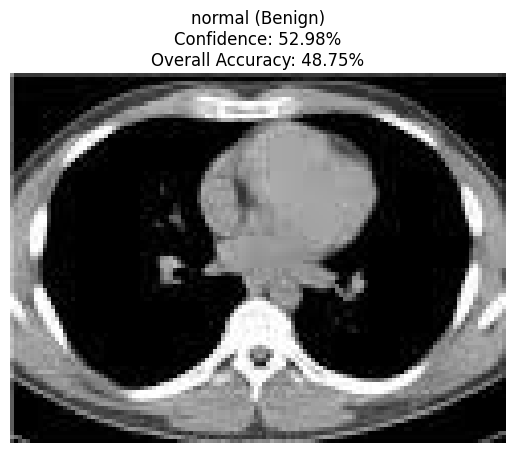

🔹 Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib (Malignant) (Confidence: 35.37%)


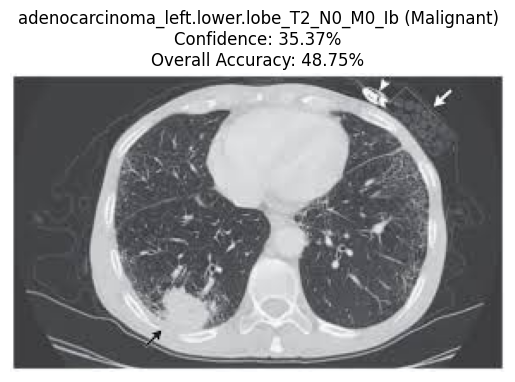

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# ✅ Enable GPU
print("✅ Available GPUs:", tf.config.list_physical_devices('GPU'))

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define Paths
dataset_path = "/content/drive/MyDrive/Lung-Cancer-Prediction/dataset"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# ✅ Image dimensions & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Data Augmentation & Preprocessing
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_gen = datagen.flow_from_directory(valid_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# ✅ Load Pretrained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ✅ Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(len(train_gen.class_indices), activation='softmax')
])

# ✅ Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Training Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[early_stopping, lr_scheduler])

# ✅ Fine-Tuning ResNet50
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# ✅ Recompile Model for Fine-Tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Fine-Tune Model
history_finetune = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[early_stopping, lr_scheduler])

# ✅ Evaluate Model
loss, accuracy = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")

# ✅ Generate Predictions for Confusion Matrix
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print Classification Report
print("🔹 Classification Report:\n", classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

# ✅ Prediction Function with Benign/Malignant Classification
def predict_image(img_path):
    if not os.path.exists(img_path):
        print(f"❌ Error: Image {img_path} not found.")
        return

    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    class_name = list(train_gen.class_indices.keys())[predicted_class]

    # Define malignant and benign class sets based on dataset
    benign_classes = {"benign", "normal"}  # Adjust according to dataset
    malignant_classes = set(train_gen.class_indices.keys()) - benign_classes

    if class_name in benign_classes:
        category = f"Benign"
    elif class_name in malignant_classes:
        category = f"Malignant"
    else:
        category = f"Unknown ({class_name})"

    print(f"🔹 Predicted: {class_name} ({category}) (Confidence: {confidence * 100:.2f}%)")
    plt.imshow(load_img(img_path))
    plt.title(f"{class_name} ({category})\nConfidence: {confidence * 100:.2f}%\nOverall Accuracy: {accuracy * 100:.2f}%")
    plt.axis('off')
    plt.show()

# ✅ Example Usage
predict_image(os.path.join(test_path, "ad.jpg"))
predict_image(os.path.join(test_path, "lc.jpeg"))
predict_image(os.path.join(test_path, "no can.jpeg"))
predict_image(os.path.join(test_path, "sq.jpeg"))

✅ Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 316 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3951 - loss: 1.5018 - val_accuracy: 0.5000 - val_loss: 0.9415 - learning_rate: 5.0000e-04
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 731ms/step - accuracy: 0.5288 - loss: 1.1025 - val_accuracy: 0.5556 - val_loss: 0.9352 - learning_rate: 5.0000e-04
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 693ms/step - accuracy: 0.5859 - loss: 0.9605 - val_accuracy: 0.5278 - val_loss: 0.9126 - learning_rate: 5.0000e-04
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 725ms/step - accuracy: 0.6264 - loss: 0.8305 - val_accuracy: 0.5694 - val_loss: 0.9867 - learning_rate: 5.0000e-04
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 689ms/step - accuracy: 0.6819 - loss: 0.7322 - val_accuracy: 0.5694 - val_loss: 0.8783 - learning_rate: 5.0000e-04
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 690ms/step - accuracy: 0.6657 - loss: 0.7431 - val_accuracy: 0.5417 - val_loss: 0.9765 - learning_rate: 5.0000e-04
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 703ms/step - accura

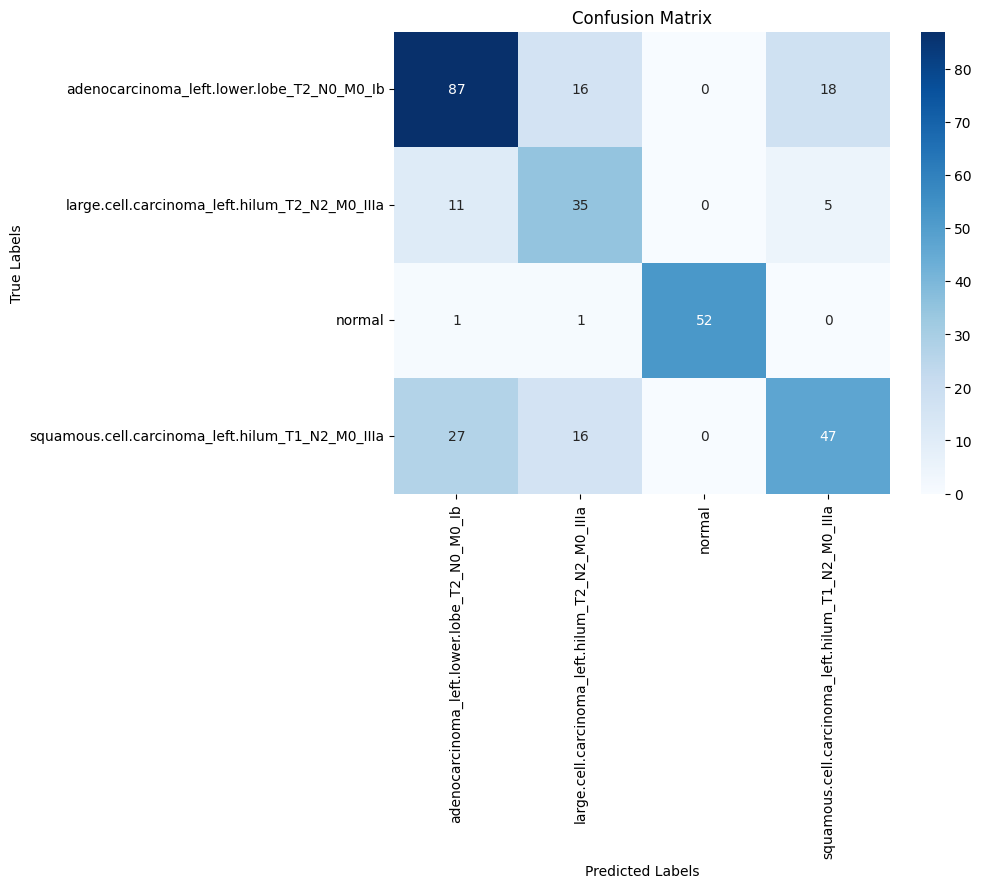

🔹 Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.69      0.72      0.70       121
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.51      0.69      0.59        51
                                          normal       1.00      0.96      0.98        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.67      0.52      0.59        90

                                        accuracy                           0.70       316
                                       macro avg       0.72      0.72      0.72       316
                                    weighted avg       0.71      0.70      0.70       316

🔹 Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib (Confidence: 48.10%)


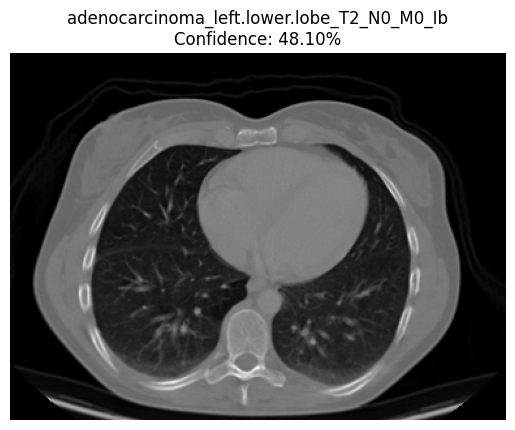

🔹 Predicted: normal (Confidence: 52.66%)


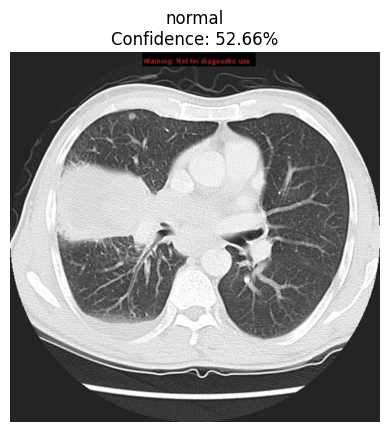

🔹 Predicted: normal (Confidence: 96.70%)


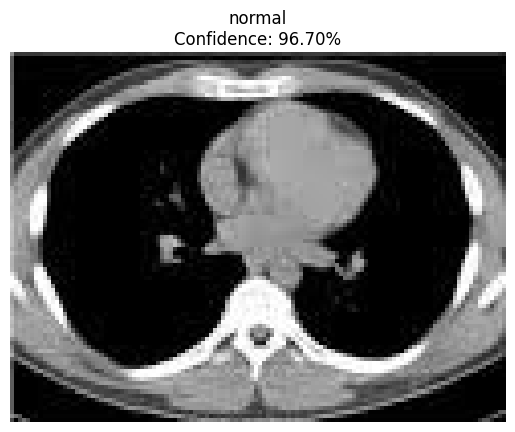

🔹 Predicted: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa (Confidence: 33.35%)


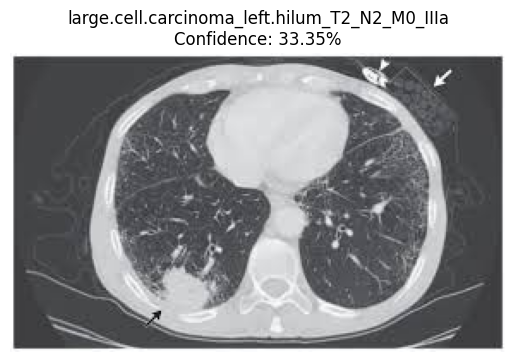

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Enable GPU
print("✅ Available GPUs:", tf.config.list_physical_devices('GPU'))

# ✅ Define Paths
dataset_path = "/content/drive/MyDrive/Lung-Cancer-Prediction/dataset"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# ✅ Image dimensions & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_gen = valid_test_datagen.flow_from_directory(valid_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = valid_test_datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# ✅ Load Pretrained MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ✅ Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(len(train_gen.class_indices), activation='softmax')
])

# ✅ Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Training Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = model.fit(train_gen, validation_data=valid_gen, epochs=15, callbacks=[early_stopping, lr_scheduler])

# ✅ Fine-Tuning MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# ✅ Recompile Model for Fine-Tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Fine-Tune Model
history_finetune = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[early_stopping, lr_scheduler])

# ✅ Evaluate Model
loss, accuracy = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")

# ✅ Generate Predictions for Confusion Matrix
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print Classification Report
print("🔹 Classification Report:\n", classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

# ✅ Prediction Function
def predict_image(img_path):
    if not os.path.exists(img_path):
        print(f"❌ Error: Image {img_path} not found.")
        return

    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    class_name = list(train_gen.class_indices.keys())[predicted_class]

    print(f"🔹 Predicted: {class_name} (Confidence: {confidence * 100:.2f}%)")
    plt.imshow(load_img(img_path))
    plt.title(f"{class_name}\nConfidence: {confidence * 100:.2f}%")
    plt.axis('off')
    plt.show()
    # ✅ Example Usage
predict_image(os.path.join(test_path, "ad.jpg"))
predict_image(os.path.join(test_path, "lc.jpeg"))
predict_image(os.path.join(test_path, "no can.jpeg"))
predict_image(os.path.join(test_path, "sq.jpeg"))

✅ Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 316 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 398s 19s/step - accuracy: 0.3189 - loss: 1.6594 - val_accuracy: 0.4861 - val_loss: 1.0883 - learning_rate: 0.0010
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 628ms/step - accuracy: 0.3963 - loss: 1.2016 - val_accuracy: 0.4444 - val_loss: 1.0935 - learning_rate: 0.0010
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 624ms/step - accuracy: 0.4738 - loss: 1.0690 - val_accuracy: 0.3472 - val_loss: 1.1313 - learning_rate: 0.0010
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.5278 - loss: 1.0638
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 634ms/step - accuracy: 0.5272 - loss: 1.0630 - val_accuracy: 0.3611 - val_loss: 1.1114 - learning_rate: 0.0010
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 631ms/step - accuracy: 0.4851 - loss: 1.0857 - val_accuracy: 0.3750 - val_loss: 1.0857 - learning_rate: 5.0000e-04
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 641ms/step - accuracy: 0.5182 - loss: 1

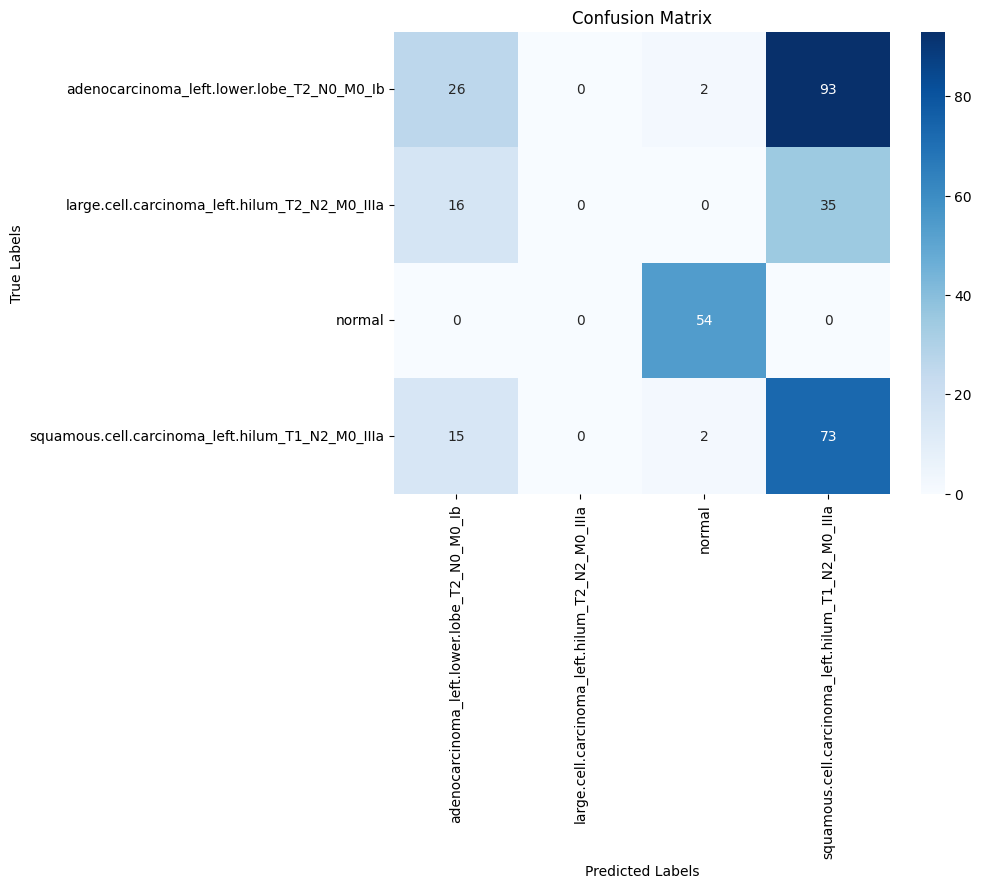

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.46      0.21      0.29       121
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.00      0.00      0.00        51
                                          normal       0.93      1.00      0.96        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.36      0.81      0.50        90

                                        accuracy                           0.48       316
                                       macro avg       0.44      0.51      0.44       316
                                    weighted avg       0.44      0.48      0.42       316

🔹 Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib (Malignant) (Confidence: 36.57%)


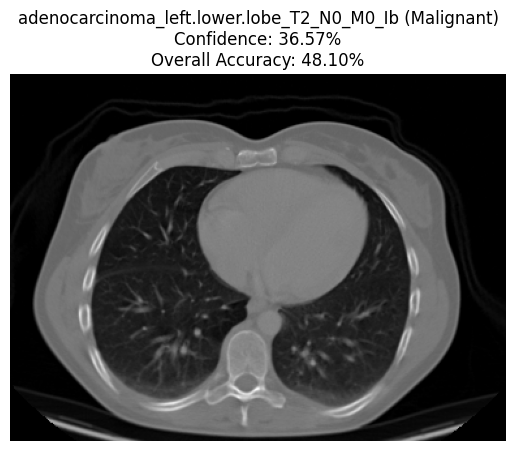

🔹 Predicted: normal (Benign) (Confidence: 95.46%)


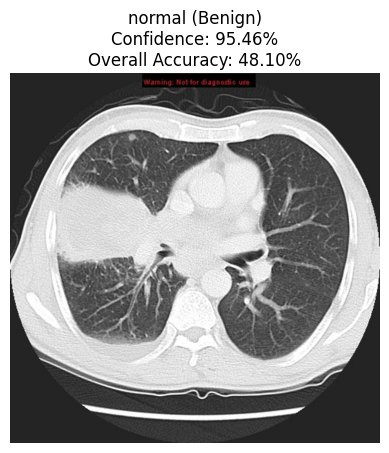

🔹 Predicted: normal (Benign) (Confidence: 87.19%)


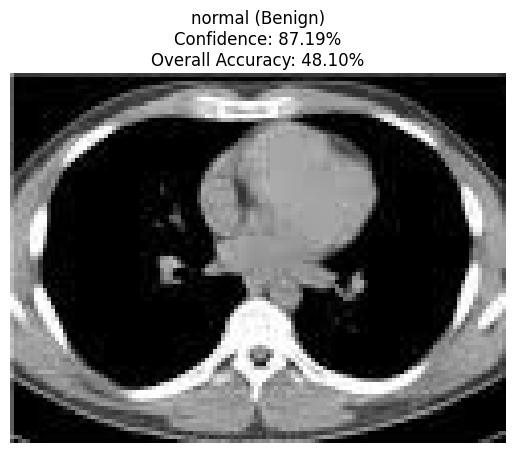

🔹 Predicted: normal (Benign) (Confidence: 76.55%)


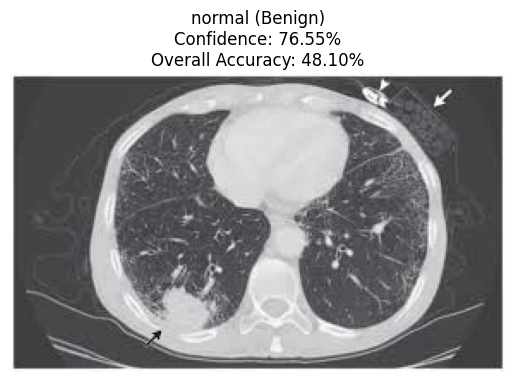

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Enable GPU
print("✅ Available GPUs:", tf.config.list_physical_devices('GPU'))

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define Paths
dataset_path = "/content/drive/MyDrive/Lung-Cancer-Prediction/dataset"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# ✅ Image dimensions & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_gen = datagen.flow_from_directory(valid_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# ✅ Load Pretrained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ✅ Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(len(train_gen.class_indices), activation='softmax')
])

# ✅ Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Training Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = model.fit(train_gen, validation_data=valid_gen, epochs=15, callbacks=[early_stopping, lr_scheduler])

# ✅ Fine-Tuning ResNet50
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# ✅ Recompile Model for Fine-Tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Fine-Tune Model
history_finetune = model.fit(train_gen, validation_data=valid_gen, epochs=15, callbacks=[early_stopping, lr_scheduler])

# ✅ Evaluate Model
loss, accuracy = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")

# ✅ Generate Predictions for Confusion Matrix
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print Classification Report
print("🔹 Classification Report:\n", classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

# ✅ Prediction Function
def predict_image(img_path):
    if not os.path.exists(img_path):
        print(f"❌ Error: Image {img_path} not found.")
        return

    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    class_name = list(train_gen.class_indices.keys())[predicted_class]

    benign_classes = {"benign", "normal"}
    malignant_classes = set(train_gen.class_indices.keys()) - benign_classes

    category = "Malignant" if class_name in malignant_classes else "Benign"

    print(f"🔹 Predicted: {class_name} ({category}) (Confidence: {confidence * 100:.2f}%)")
    plt.imshow(load_img(img_path))
    plt.title(f"{class_name} ({category})\nConfidence: {confidence * 100:.2f}%\nOverall Accuracy: {accuracy * 100:.2f}%")
    plt.axis('off')
    plt.show()

# ✅ Example Usage
predict_image(os.path.join(test_path, "ad.jpg"))
predict_image(os.path.join(test_path, "lc.jpeg"))
predict_image(os.path.join(test_path, "no can.jpeg"))
predict_image(os.path.join(test_path, "sq.jpeg"))